## 1 Data Preprocessing

In [169]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
from time import sleep
import math

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

target_symbol = 'XAUUSD'

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data = tv.get_hist(symbol=target_symbol, exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

sleep(1)

forex_data_lowertf = tv.get_hist(symbol=target_symbol, exchange='ICMARKETS',
                              interval=Interval.in_5_minute, n_bars=1000)


prices = forex_data['close']
print(prices)

# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

datetime
2024-09-12 06:00:00    2513.12
2024-09-12 06:15:00    2513.93
2024-09-12 06:30:00    2514.64
2024-09-12 06:45:00    2515.89
2024-09-12 07:00:00    2516.62
                        ...   
2024-11-12 21:45:00    2598.21
2024-11-12 22:00:00    2597.98
2024-11-12 22:15:00    2598.28
2024-11-12 22:30:00    2600.30
2024-11-12 22:45:00    2600.07
Name: close, Length: 4000, dtype: float64


In [170]:
# Apply Savitzky-Golay filter to get the trend
# Note that in scipy Savitzky-Golay filter, the last elements are calculated by padding,
# so we would remove them to ensure an accurate trend data

yvalues_trend = []
yvalues_seasonal = []

yvalues = prices[:]
yvalues_trend.append(savgol_filter(yvalues,19,1))
yvalues_trend.append(savgol_filter(yvalues_trend[0],59,1))
yvalues_trend.append(savgol_filter(yvalues_trend[1],179,1))
yvalues_seasonal.append(yvalues-yvalues_trend[0])
yvalues_seasonal.append(yvalues_trend[0]-yvalues_trend[1])
yvalues_seasonal.append(yvalues_trend[1]-yvalues_trend[2])

yvalues_trend_forecast    = [None] * 3
yvalues_seasonal_forecast = [None] * 3
results_trend             = [None] * 3
results_seasonal          = [None] * 3

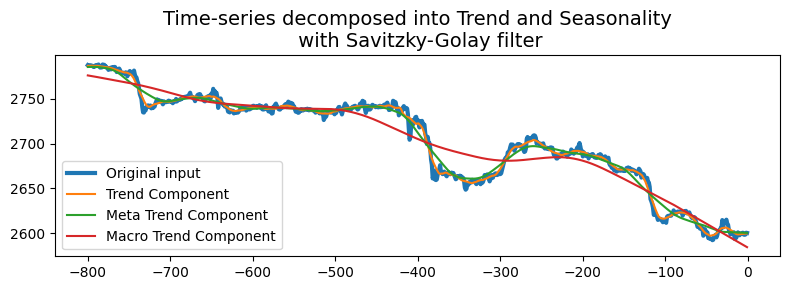

In [171]:
# Optional: Plot the decomposed time series
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-800,0), yvalues[-800:], label='Original input',linewidth=3)
ax.plot(np.arange(-800,0), yvalues_trend[0][-800:], label='Trend Component')
ax.plot(np.arange(-800,0), yvalues_trend[1][-800:], label='Meta Trend Component')
ax.plot(np.arange(-800,0), yvalues_trend[2][-800:], label='Macro Trend Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()

## 2 Definition of Parameters and Functions

Trends can have different scales, each needing tailored forecasting tools:
- Large Scale (Red): Simple linear models suffice.
- Medium Scale (Green): Polynomial fitting works well.
- Small Scale (Orange): Clear cyclic patterns best handled by FFT.

For practical, short-term applications, the medium scale is often sufficient, minimizing major forecast deviations. 

In the past, we attempted to use ARIMA models to predict the orange trend. However, due to its inherent cyclic nature, ARIMA did not provide accurate results. Then we shifted to using FFT directly on the orange trend, but since FFT should be applied after detrending, the forecasts deviated substantially.

Now we will do the forecast like this:
- Medium scale trend: Polynomial fitting
- Medium scale seasonal / Small scale trend: FFT
- Small scale seasonal: FFT

Validation is need for both Polynomial fitting and FFT.

In [172]:
# Definition of Forecast Parameters
forecast_elements = 40

t1_validation_elements_list = np.arange(16, 81, 8)
t1_input_elements_list      = np.arange(12, 33, 4)

s1_validation_elements_list = np.arange(16, 25, 4)
s1_harmonics_list           = np.arange(10, 61, 10)
s1_input_elements_list      = np.arange(400, 1601, 10)

s0_validation_elements_list = [8]
s0_harmonics_list           = np.arange(20, 60, 10)
s0_input_elements_list      = np.arange(200, 800, 4)

visualization_elements_original = 40
visualization_elements_forecast = 24

In [173]:
def poly_forecast(signal, forecast_elements, fit_window=None, degree=2):
    """
    Extend a time series using polynomial fitting on a portion of the end of the series.

    Parameters:
    - signal: numpy array of original time series data.
    - forecast_elements: int, number of future points to extend.
    - degree: int, degree of the polynomial to fit.
    - fit_window: int or None, number of data points from the end of the series to use for fitting.
                  If None, use the entire series.

    Returns:
    - extended_time_series: numpy array of the original and extended time series.
    """
    # Determine the portion of the time series to use for fitting
    if fit_window is None or fit_window > len(signal):
        fit_window = len(signal)
    
    # Select the last `fit_window` points for fitting
    time_points = np.arange(len(signal) - fit_window, len(signal))
    fit_series = signal[-fit_window:]
    
    # Fit a polynomial of the specified degree to the selected portion of the series
    coefficients = np.polyfit(time_points, fit_series, degree)
    poly_func = np.poly1d(coefficients)
    
    # Create extended time points
    extended_time_points = np.arange(len(signal), len(signal) + forecast_elements)
    
    # Use the polynomial to predict extended values
    extended_values = poly_func(extended_time_points)
    
    # Combine the original series with the extended values
    extended_time_series = np.concatenate((signal, extended_values))
    
    return extended_time_series

In [174]:
def fft_forecast(signal, forecast_elements, fit_window=None, target_harmonics=40, trend_factor=0, trend_strength=0):
    # Store the full length of the original signal
    original_length = len(signal)
    
    # Use only the last `window` elements if specified for FFT, otherwise use the entire signal
    if fit_window is not None and fit_window < original_length:
        signal_fft = signal[-fit_window:]
    else:
        signal_fft = signal
    
    # Extend the FFT portion of the signal with a linear trend if specified
    if trend_strength > 0:
        trend_extension = signal_fft[-1] + trend_factor * np.arange(1, trend_strength + 1)
        extended_signal = np.concatenate((signal_fft, trend_extension))
    else:
        extended_signal = signal_fft
    
    N = len(extended_signal)
    
    # Perform FFT on the extended signal
    fft_result = np.fft.fft(extended_signal)
    fft_freq = np.fft.fftfreq(N)
    
    # Retain non-negative frequencies
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]
    
    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]
    
    # Create extended indices including future points
    extended_indices = np.arange(N + forecast_elements)
    
    # Reconstruct the signal using the selected harmonics
    reconstructed_signal = np.zeros(N + forecast_elements)
    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency
        
        if frequency == 0:
            # DC component
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    # Define the length of the blend window as half of the original signal length
    blend_window = original_length // 2 if fit_window is None else fit_window // 2
    
    # Initialize the blended signal with the correct length
    blended_signal = np.zeros(original_length + forecast_elements)
    
    # Copy the original signal into the beginning of blended_signal
    blended_signal[:original_length - blend_window] = signal[:original_length - blend_window]
    
    # Blend the end of the original signal with the reconstructed signal
    for i in range(0, blend_window):  # Iterate through the last `blend_window` elements of the original signal
        idx = original_length - blend_window + i
        alpha = i / blend_window  # Adjusted alpha calculation to range from 0 to 1
        blended_signal[idx] = (1 - alpha) * signal[idx] + alpha * reconstructed_signal[blend_window+i]
    
    # Append the forecasted portion from the reconstructed signal
    blended_signal[original_length:] = reconstructed_signal[fit_window:fit_window+forecast_elements]
    
    return blended_signal


In [175]:
def poly_forecast_validation(signal, forecast_elements, validation_elements_list, input_elements_list, degree=2):
    
    results = []

    for validation_elements in validation_elements_list:
        for input_elements in input_elements_list:
            
            signal_forecast = poly_forecast(signal[:-validation_elements], validation_elements+forecast_elements, input_elements, degree)

            # Convert forecasts to numpy arrays if they are pandas Series
            if isinstance(signal_forecast, pd.Series):
                signal_forecast = signal_forecast.to_numpy()
            if isinstance(signal, pd.Series):
                signal = signal.to_numpy()
            
            # Extract validation portions
            actual_validation = signal[-validation_elements:]
            forecast_validation = signal_forecast[-validation_elements - forecast_elements:-forecast_elements]

            # Calculate distances
            dtw_value = dtw.distance(actual_validation, forecast_validation)
            rmse_value = np.sqrt(mean_squared_error(actual_validation, forecast_validation))

            # Store the results
            results.append({
                'poly_validation_elements': validation_elements,
                'poly_input_elements': input_elements,
                'rmse_validation': rmse_value,
                'dtw_validation': dtw_value
            })

    # Convert results to DataFrame and sort
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by='rmse_validation', ascending=True).head(20)
    return df_results


In [176]:
def fft_forecast_validation(signal, forecast_elements, validation_elements_list, input_elements_list, harmonics_list):

    results = []

    # Ensure signal is a numpy array
    if isinstance(signal, pd.Series):
        signal = signal.to_numpy()

    # Iterate over all combinations of validation_elements, input_elements, and harmonics
    for validation_elements in validation_elements_list:
        for input_elements in input_elements_list:
            for harmonics in harmonics_list:
                
                # Define the total number of elements to forecast (validation + forecast)
                total_forecast_length = validation_elements + forecast_elements

                # Prepare the training signal by excluding the last 'validation_elements' points
                training_signal = signal[:-validation_elements]

                # Perform FFT-based forecasting
                try:
                    signal_forecast = fft_forecast(
                        signal=training_signal,
                        forecast_elements=total_forecast_length,
                        fit_window=input_elements,
                        target_harmonics=harmonics,
                        trend_factor=0,        # Set to 0 or adjust as needed
                        trend_strength=0       # Set to 0 or adjust as needed
                    )
                except ValueError as e:
                    print(f"ValueError for validation_elements={validation_elements}, "
                          f"input_elements={input_elements}, harmonics={harmonics}: {e}")
                    continue  # Skip this combination if an error occurs

                # Extract validation portions
                actual_validation = signal[-validation_elements:]
                forecast_validation = signal_forecast[-validation_elements - forecast_elements:-forecast_elements]

                # Calculate RMSE and DTW distance
                rmse_value = np.sqrt(mean_squared_error(actual_validation, forecast_validation))
                dtw_value = dtw.distance(actual_validation, forecast_validation)

                # Store the results
                results.append({
                    'fft_validation_elements': validation_elements,
                    'fft_input_elements': input_elements,
                    'fft_harmonics': harmonics,
                    'rmse_validation': rmse_value,
                    'dtw_validation': dtw_value
                })

    # Convert the results list to a pandas DataFrame
    df_results = pd.DataFrame(results)

    # Sort the DataFrame by RMSE in ascending order and select the top 20 results
    df_results = df_results.sort_values(by='rmse_validation', ascending=True).head(40)
    df_results = df_results.sort_values(by='dtw_validation', ascending=True).head(20)

    return df_results


In [177]:
def find_optimal_clusters(data, max_clusters=4):
    """Find optimal number of clusters using silhouette score."""
    # data is expected to be a 2D array of shape (n_samples, n_timepoints)
    n_samples = data.shape[0]
    data_reshaped = data.reshape(n_samples, -1)  # Ensure data is 2D
    
    # Try different numbers of clusters
    silhouette_scores = []
    for k in range(2, min(max_clusters + 1, n_samples)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data_reshaped)
        score = silhouette_score(data_reshaped, cluster_labels)
        silhouette_scores.append(score)
    
    # Return optimal number of clusters
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_k

## 3.1 Medium Trend Forecast

In [178]:
results_trend[1] = poly_forecast_validation(yvalues_trend[1], forecast_elements, t1_validation_elements_list, t1_input_elements_list, degree=2)
results_trend[1]

,poly_validation_elements,poly_input_elements,rmse_validation,dtw_validation
0,16,12,2.351972e-12,9.407886e-12
1,16,16,5.036777e-01,2.014711e+00
11,24,32,6.546313e-01,1.561835e+00
12,32,12,8.421589e-01,4.189340e+00
37,64,16,9.975905e-01,2.411637e+00
36,64,12,1.068972e+00,1.054968e+00
10,24,28,1.105529e+00,5.378203e+00
30,56,12,1.276611e+00,5.130103e+00
13,32,16,1.384253e+00,5.592941e+00
2,16,20,1.588666e+00,6.354664e+00


In [179]:
t1_forecast_all = []

for _, row in results_trend[1][:10].iterrows():
    validation_elements = int(row['poly_validation_elements'])
    input_elements = int(row['poly_input_elements'])
    
    signal_forecast = poly_forecast(yvalues_trend[1][:-validation_elements], validation_elements+forecast_elements, input_elements)
    t1_forecast_all.append(signal_forecast)

t1_forecast_mean = np.mean(t1_forecast_all, axis=0)

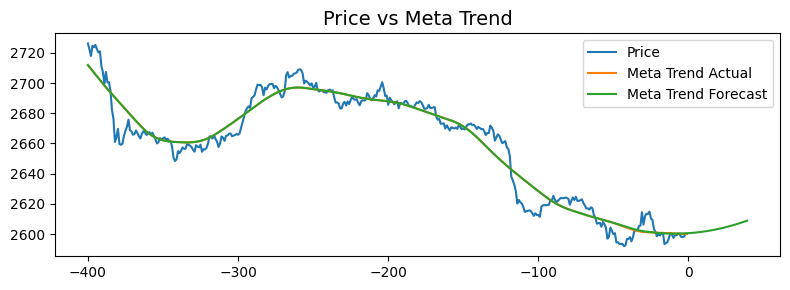

In [180]:
# Optional: Plot the trend1_forecast_mean 
visible_elements = 400
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-visible_elements,0), yvalues[-visible_elements:], label='Price')
ax.plot(np.arange(-visible_elements,0), yvalues_trend[1][-visible_elements:], label='Meta Trend Actual')
ax.plot(np.arange(-visible_elements,forecast_elements), t1_forecast_mean[-visible_elements-forecast_elements:], label='Meta Trend Forecast')

ax.legend()
ax.set_title('Price vs Meta Trend', fontsize=14)
plt.tight_layout()
plt.show()

## 3.2 Medium Seasonal / Small Trend Forecast

In [181]:
results_seasonal[1] = fft_forecast_validation(yvalues_seasonal[1], forecast_elements, s1_validation_elements_list, s1_input_elements_list, s1_harmonics_list)
results_seasonal[1] 

,fft_validation_elements,fft_input_elements,fft_harmonics,rmse_validation,dtw_validation
182,16,700,30,0.252482,0.660563
473,16,1180,60,0.385381,0.745546
503,16,1230,60,0.299145,0.801268
502,16,1230,50,0.389165,0.824903
1925,24,1180,60,0.439159,0.870138
1433,20,1570,60,0.294347,0.889573
472,16,1180,50,0.426764,0.895712
829,20,570,20,0.517987,0.897619
707,16,1570,60,0.459767,0.919504
1555,24,570,20,0.386067,0.933604


In [182]:
s1_forecast_all = []

for _, row in results_seasonal[1][:20].iterrows():
    validation_elements = int(row['fft_validation_elements'])
    input_elements = int(row['fft_input_elements'])
    harmonics = int(row['fft_harmonics'])
    signal_forecast = fft_forecast(yvalues_seasonal[1][:-validation_elements], validation_elements+forecast_elements, input_elements, harmonics, 0, 0)
    s1_forecast_all.append(signal_forecast)

s1_forecast_mean = np.mean(s1_forecast_all, axis=0)

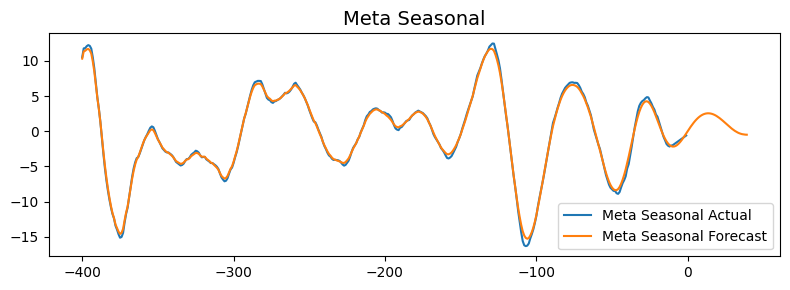

In [183]:
# Optional: Plot the s1_forecast_mean 
visible_elements = 400
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-visible_elements,0), yvalues_seasonal[1][-visible_elements:], label='Meta Seasonal Actual')
ax.plot(np.arange(-visible_elements,40), s1_forecast_mean[-visible_elements-forecast_elements:], label='Meta Seasonal Forecast')

ax.legend()
ax.set_title('Meta Seasonal', fontsize=14)
plt.tight_layout()
plt.show()

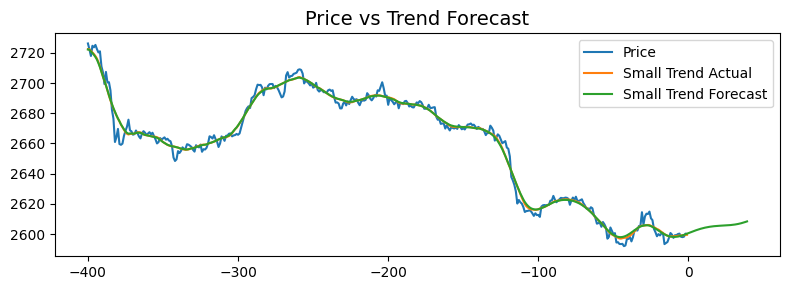

In [184]:
# Optional: Plot the s1_forecast_mean with t1_forecast_mean and price
visible_elements = 400
t0_forecast_mean = t1_forecast_mean + s1_forecast_mean
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-visible_elements,0), yvalues[-visible_elements:], label='Price')
ax.plot(np.arange(-visible_elements,0), yvalues_trend[0][-visible_elements:], label='Small Trend Actual')
ax.plot(np.arange(-visible_elements,40), t0_forecast_mean[-visible_elements-forecast_elements:], label='Small Trend Forecast')

ax.legend()
ax.set_title('Price vs Trend Forecast', fontsize=14)
plt.tight_layout()
plt.show()

## 3.3 Small Seasonal Forecast

In [185]:
results_seasonal[0] = fft_forecast_validation(yvalues_seasonal[0], forecast_elements, s0_validation_elements_list, s0_input_elements_list, s0_harmonics_list)
results_seasonal[0] 

,fft_validation_elements,fft_input_elements,fft_harmonics,rmse_validation,dtw_validation
391,8,588,50,0.795252,1.673991
326,8,524,40,0.960115,1.835676
8,8,208,20,1.037427,1.851900
165,8,364,30,0.960774,2.000753
327,8,524,50,0.783081,2.050400
237,8,436,30,0.823820,2.205680
153,8,352,30,1.069659,2.244341
303,8,500,50,0.920488,2.245337
587,8,784,50,1.049634,2.446789
414,8,612,40,0.957934,2.464061


In [186]:
s0_forecast_all = []

for _, row in results_seasonal[0][:20].iterrows():
    validation_elements = int(row['fft_validation_elements'])
    input_elements = int(row['fft_input_elements'])
    harmonics = int(row['fft_harmonics'])
    signal_forecast = fft_forecast(yvalues_seasonal[0][:-validation_elements], validation_elements+forecast_elements, input_elements, harmonics, 0, 0)
    s0_forecast_all.append(signal_forecast)

s0_forecast_mean = np.mean(s0_forecast_all, axis=0)

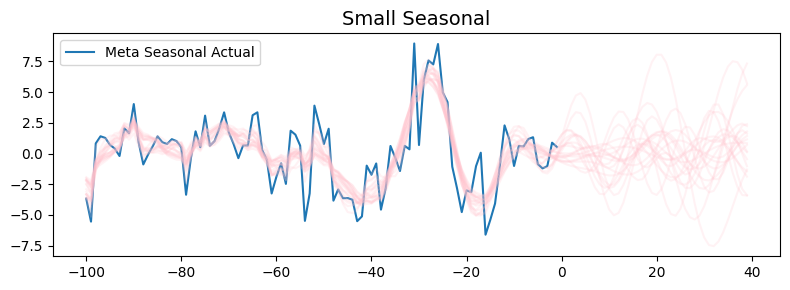

In [187]:
# Optional: Plot the s0_forecast_mean 
visible_elements = 100
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-visible_elements,0), yvalues_seasonal[0][-visible_elements:], label='Meta Seasonal Actual')
for i in range(0,20):
    ax.plot(np.arange(-visible_elements,40), s0_forecast_all[i][-visible_elements-forecast_elements:], color='pink', alpha=0.2)

ax.legend()
ax.set_title('Small Seasonal', fontsize=14)
plt.tight_layout()
plt.show()

In [188]:
# Clustering

# Convert to numpy arrays for easier manipulation
s0_forecast_all = np.array(s0_forecast_all)

# Get the validation and first equal amount of forecast data for clustering
validation_elements = s0_validation_elements_list[0]
end_idx = -forecast_elements + validation_elements
start_idx = -forecast_elements - validation_elements
clustering_data = s0_forecast_all[:, start_idx:end_idx]
n_samples = clustering_data.shape[0]
data_reshaped = clustering_data.reshape(n_samples, -1)

# Find optimal number of clusters
n_clusters = find_optimal_clusters(clustering_data, 3)

# Perform clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(data_reshaped)

# Group forecasts by cluster
cluster_members = defaultdict(list)
for idx, label in enumerate(cluster_labels):
    cluster_members[label].append(idx)

# Calculate cluster means and intra-cluster distances
cluster_means = {}
intra_cluster_distances = {}
for label, indices in cluster_members.items():
    cluster_data = s0_forecast_all[indices]
    cluster_means[label] = np.mean(cluster_data, axis=0)
    
    # Compute intra-cluster distance (mean pairwise distance within the cluster)
    distances = []
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            dist = np.linalg.norm(cluster_data[i] - cluster_data[j])
            distances.append(dist)
    if distances:
        intra_cluster_distance = np.mean(distances)
    else:
        intra_cluster_distance = 0  # Single member in cluster
    intra_cluster_distances[label] = intra_cluster_distance


## 4 TFO

In [189]:
# TFO Calculation Functions

def essf(series, period):
    """Ehlers' SuperSmoother Filter (ESSF)"""
    SQRT2xPI = np.sqrt(2.0) * np.pi
    alpha = SQRT2xPI / period
    beta = np.exp(-alpha)
    coef2 = -beta ** 2
    coef1 = 2.0 * beta * np.cos(alpha)
    coef0 = 1.0 - coef1 - coef2

    # Calculate sma2
    sma2 = (series + series.shift(1).fillna(series)) * 0.5

    # Initialize ESSF array
    ess = np.full(len(series), np.nan)
    ess[0] = sma2.iloc[0]

    for t in range(1, len(series)):
        sma2_t = sma2.iloc[t]
        ess_t1 = ess[t - 1]
        ess_t2 = ess[t - 2] if t - 2 >= 0 else 0.0

        ess[t] = coef0 * sma2_t + coef1 * ess_t1 + coef2 * ess_t2

    return pd.Series(ess, index=series.index)

def sum_diffs(series, period):
    """Sum of Differences"""
    E = np.zeros(len(series))
    for i in range(1, period + 1):
        shifted_series = series.shift(i).fillna(0)
        E += (series - shifted_series)
    E /= period
    return pd.Series(E, index=series.index)

def ema_recursive(series, period):
    """Exponential Moving Average (EMA) calculated recursively"""
    coef0 = 2.0 / (period + 1.0)
    coef1 = 1.0 - coef0
    EMA = np.full(len(series), np.nan)
    EMA[0] = series.iloc[0]

    for t in range(1, len(series)):
        series_t = series.iloc[t]
        EMA_t1 = EMA[t - 1]
        EMA[t] = coef0 * series_t + coef1 * EMA_t1

    return pd.Series(EMA, index=series.index)

def fRMS(series, period):
    """Fast Root Mean Square (fRMS)"""
    squared_series = series ** 2
    ema_squared = ema_recursive(squared_series, period)
    sqrt_ema = np.sqrt(ema_squared)
    result = np.nan_to_num(series / sqrt_ema, 0)
    return result

def trendflex(series, period_essf, period_tflx, period_frms):
    """Ehlers' TrendFlex Oscillator (TFO)"""
    essf_filtered = essf(series, period_essf)
    sum_diffs_filtered = sum_diffs(essf_filtered, period_tflx)
    tfo = fRMS(sum_diffs_filtered, period_frms)
    return tfo


# Parameters for Calculating TFO
periodTrendFlex = 20
useSuperSmootherOverride = False
periodSuperSmoother = 7.5
postSmooth = 33.0
if not useSuperSmootherOverride:
    periodSuperSmoother = periodTrendFlex * 0.5

# Calculate TFO
forex_data_lowertf['TFO'] = trendflex(forex_data_lowertf['close'], periodSuperSmoother, periodTrendFlex, postSmooth)

# Cut TFO data into suitable length (M15 to M5)
tfo_values = forex_data_lowertf['TFO'].iloc[-(visualization_elements_original)*3:]

## 5 Plotting

In [192]:
# Prepare common data slices and indices
len_original_slice = visualization_elements_original
forecast_slice_start_idx = -forecast_elements-visualization_elements_original
forecast_slice_end_idx   = -forecast_elements+visualization_elements_forecast
original_slice_idx_list = np.arange(-visualization_elements_original, 0)
forecast_slice_idx_list = np.arange(-visualization_elements_original, visualization_elements_forecast)
seasonal_validation_elements = s0_validation_elements_list[0]

# Prepare the slices, which is originally in different lengths
prices_slice = yvalues[-visualization_elements_original:]
t0_forecast_mean_slice = t0_forecast_mean[forecast_slice_start_idx:forecast_slice_end_idx]
t1_forecast_mean_slice = t1_forecast_mean[forecast_slice_start_idx:forecast_slice_end_idx]
yvalues_seasonal_slice = yvalues_seasonal[0][-visualization_elements_original:]
s0_forecast_all_slice = np.array(s0_forecast_all)[:, forecast_slice_start_idx:forecast_slice_end_idx]
cluster_means_slice = {}
for label, data in cluster_means.items():
    cluster_means_slice[label] = np.array(data)[forecast_slice_start_idx:forecast_slice_end_idx]

# Get the last data time
last_datetime = forex_data.index[-1]

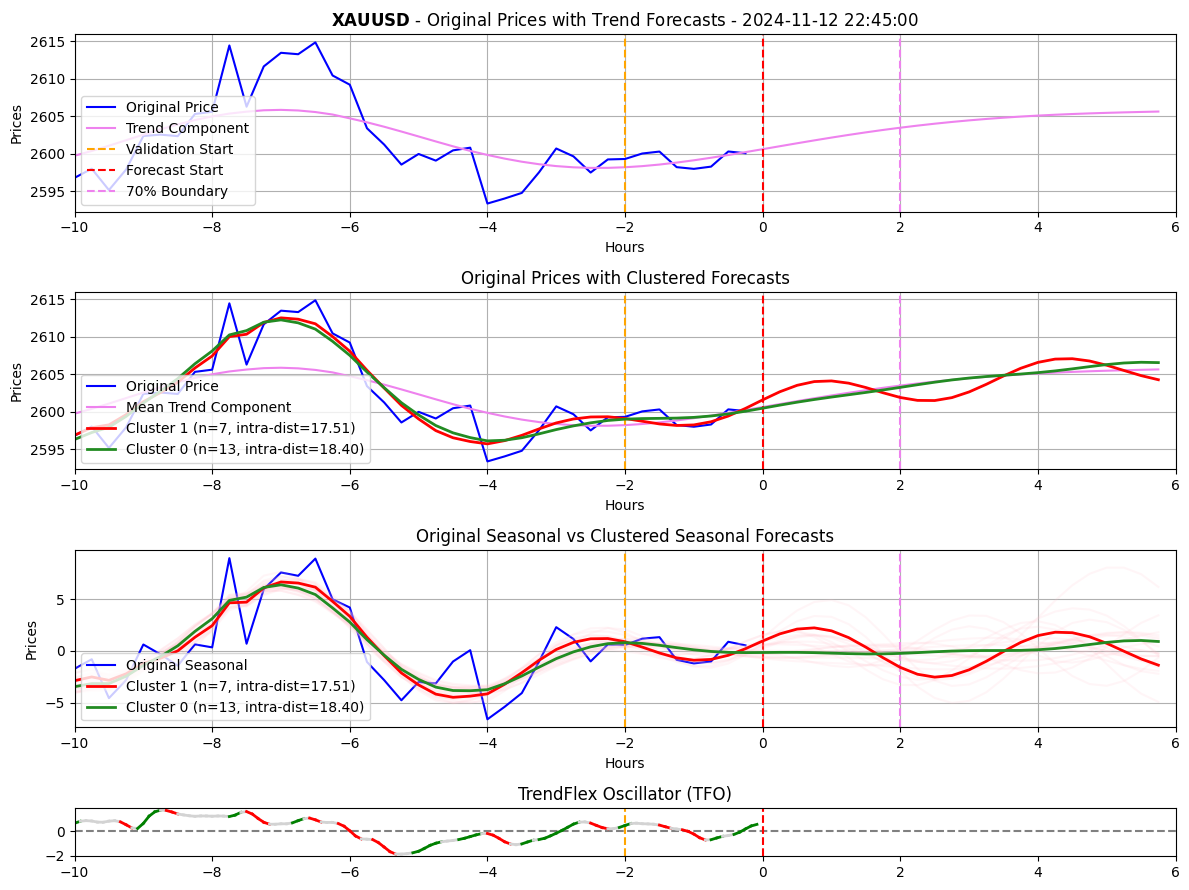

In [195]:
# Plotting
plt.figure(figsize=(12, 9))
colors = ['forestgreen', 'red', 'darkorange', 'dodgerblue']

# Plot 1: Original Price with Trend Forecasts
plt.subplot(7, 1, (1,2))
plt.plot(original_slice_idx_list / 4, prices_slice, label="Original Price", color='blue')
plt.plot(forecast_slice_idx_list / 4, t0_forecast_mean_slice, label='Trend Component', color='violet')
plt.axvline(x=-seasonal_validation_elements / 4, color='orange', linestyle='--', label="Validation Start")
plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
plt.axvline(x=seasonal_validation_elements / 4, color='violet', linestyle='--', label="70% Boundary")
plt.legend(loc = "lower left")
plt.title(rf"$\mathbf{{{target_symbol}}}$ - Original Prices with Trend Forecasts - {last_datetime}")
plt.xlim(-math.ceil((visualization_elements_original)/4), math.ceil(visualization_elements_forecast/4))
plt.xlabel("Hours")
plt.ylabel("Prices")
plt.grid(True)



# Plot 2: Original Price with Clustered Forecasts
plt.subplot(7, 1, (3,4))
plt.plot(original_slice_idx_list / 4, prices_slice, label="Original Price", color='blue')
plt.plot(forecast_slice_idx_list / 4, t0_forecast_mean_slice, label='Mean Trend Component', color='violet')
plt.axvline(x=-seasonal_validation_elements / 4, color='orange', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=seasonal_validation_elements / 4, color='violet', linestyle='--')
for label, indices in cluster_members.items():
    plt.plot(
        forecast_slice_idx_list / 4,
        t0_forecast_mean_slice+cluster_means_slice[label],
        color=colors[label],
        linewidth=2,
        label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
    )
plt.legend(loc = "lower left")
plt.title(f"Original Prices with Clustered Forecasts")
plt.xlim(-math.ceil((visualization_elements_original)/4), math.ceil(visualization_elements_forecast/4))
plt.xlabel("Hours")
plt.ylabel("Prices")
plt.grid(True)

# Plot 3: Original Seasonal vs Clustered Seasonal Forecasts
plt.subplot(7, 1, (5,6))
plt.plot(original_slice_idx_list / 4, yvalues_seasonal_slice, label="Original Seasonal", color='blue')
plt.axvline(x=-seasonal_validation_elements / 4, color='orange', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
plt.axvline(x=seasonal_validation_elements / 4, color='violet', linestyle='--')
for row in s0_forecast_all_slice:
    plt.plot(forecast_slice_idx_list / 4, row, color='pink', alpha=0.15)
for label, indices in cluster_members.items():
    plt.plot(
        forecast_slice_idx_list / 4,
        cluster_means_slice[label],
        color=colors[label],
        linewidth=2,
        label=f'Cluster {label} (n={len(indices)}, intra-dist={intra_cluster_distances[label]:.2f})'
    )
plt.legend(loc = "lower left")
plt.title(f"Original Seasonal vs Clustered Seasonal Forecasts")
plt.xlim(-math.ceil((visualization_elements_original)/4), math.ceil(visualization_elements_forecast/4))
plt.xlabel("Hours")
plt.ylabel("Prices")
plt.grid(True)

# Plot 4: TFO
tfo_slope = tfo_values.diff()
plt.subplot(7, 1, 7)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(x=-seasonal_validation_elements / 4, color='orange', linestyle='--')
plt.axvline(x=0, color='red', linestyle='--')
for i in range(1, len(tfo_values)):
    tfoidx = [(i-len(tfo_values)-1)/12, (i-len(tfo_values))/12]
    if tfo_slope.iloc[i] >= 0.1:
        plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='green', linewidth=2)
    elif tfo_slope.iloc[i] <= -0.1:
        plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='red', linewidth=2)
    else:
        plt.plot(tfoidx, [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='lightgrey', linewidth=2)
plt.xlim(-math.ceil((visualization_elements_original)/4), math.ceil(visualization_elements_forecast/4))
plt.title('TrendFlex Oscillator (TFO)')

plt.tight_layout()
plt.show()
    